<a href="https://colab.research.google.com/github/kindustrii/doiit-grundlagen-spracherkennung/blob/main/doiit_grundlagen_der_ki_spracherkennung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Wir setzen einen random seed, um die Reproduzierbarkeit sicherzustellen
tf.random.set_seed(seed=13)
np.random.seed(seed=13)
# Anzahl Abtastungen für die Konvertierungen
sample_rate = 4000

# Datensatz laden

In [2]:
data_dir = pathlib.Path('data/free-spoken-digit-dataset-1.0.10')
if not data_dir.exists():
  tf.keras.utils.get_file(
      fname='v1.0.10.zip',
      origin="https://github.com/Jakobovski/free-spoken-digit-dataset/archive/v1.0.10.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

16056320/Unknown - 1s 0us/step

# Datensatz untersuchen

Wir speichern alle Dateinamen in eine Liste uns sehen uns die ersten 20 davon an. 

In [3]:
# Die Bezeichnungen der ersten 10 Dateien anzeigen
files = tf.io.gfile.glob(str(data_dir) + '/recordings/*')
files[:10]

['data/free-spoken-digit-dataset-1.0.10/recordings/3_nicolas_38.wav',
 'data/free-spoken-digit-dataset-1.0.10/recordings/0_yweweler_46.wav',
 'data/free-spoken-digit-dataset-1.0.10/recordings/4_nicolas_37.wav',
 'data/free-spoken-digit-dataset-1.0.10/recordings/0_george_22.wav',
 'data/free-spoken-digit-dataset-1.0.10/recordings/2_jackson_42.wav',
 'data/free-spoken-digit-dataset-1.0.10/recordings/5_george_17.wav',
 'data/free-spoken-digit-dataset-1.0.10/recordings/0_yweweler_27.wav',
 'data/free-spoken-digit-dataset-1.0.10/recordings/8_theo_18.wav',
 'data/free-spoken-digit-dataset-1.0.10/recordings/4_nicolas_47.wav',
 'data/free-spoken-digit-dataset-1.0.10/recordings/3_jackson_8.wav']

Die Audiodateien sind in dem Format {digitLabel} {Speakername} {Index} .wav benannt. Das bedeutet, dass in der Datei 9_nicolas_2.wav die Ziffer 9 das Label darstellt und wir somit auf der Audiodatei eine Person hören werden, die auf Englisch "nine" sagt. Das testen wir am besten gleich und hören uns die Datei an.

In [4]:
print('Wir hoeren uns folgende Beispieldatei an: 9_nicolas_2.wav')
display.display(display.Audio('data/free-spoken-digit-dataset-1.0.10/recordings/9_nicolas_2.wav'))

Wir hoeren uns folgende Beispieldatei an: 9_nicolas_2.wav


# Aufteilung in Training-, Validierung- und Test-Daten

In [5]:
# Vollständige Dateinamen mit Pfad in die Liste file_paths laden
filenames = tf.io.gfile.glob(str(data_dir) + '/recordings/*')
filenames_origin = filenames
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Anzahl Dateien: ',num_samples)

Anzahl Dateien:  3000


Aufteilen der 3000 Deitein in Training, Validierung und Test Datensaetze

In [6]:
# Aufteilen der 3000 Dateien in Training, Validierung und Test Datensätze
train_files = filenames[:2400]
val_files = filenames[2400:2400+300]
test_files = filenames[-300:]

print('Anzahl Dateien Training: ', len(train_files))
print('Anzahl Dateien Validation: ', len(val_files))
print('Anzahl Dateien: ', len(test_files))

Anzahl Dateien Training:  2400
Anzahl Dateien Validation:  300
Anzahl Dateien:  300


# Audiodateien und ihre Labels einlesen

Die Audiodateien liegen uns als zunächst als Binärdateien vor und müssen deshalb in numerische Tensoren konvertiert werden. Mit tf.audio.decode_wav können wir die WAV-Datei entsprechend konvertieren und erhalten einen Tensor mit Abtastrate zurück. Zusätzlich werden die Amplituden auf den Bereich [-1.0,1.0] normalisiert.

In [7]:
def decode_audio(audio_binary):
  '''Binäre Audiodatei in einen Tensor konvertieren'''
  audio, _ = tf.audio.decode_wav(audio_binary,desired_samples=sample_rate,)
  
  return tf.squeeze(audio, axis=-1)

def get_waveform(file_path):
  '''Audiodatei laden und an Funktion zur Konvertierung uebergeben'''
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)

  return waveform

# Mit der folgenden Funktion können wir aus dem Namen der Datei 
# das zugehörige Label extrahieren.
def get_label(file_path):
  '''Extrahiert das Label aus der vollstaendigen Dateibezeichnung'''
  label = str(file_path).split('/')[3][0]

  return label

# Die oben definierten Funktionen verwenden wir jetzt um die Trainingsdaten 
# in ein tf.data.Dataset zu wandeln. In diesem Datensatz sind die Wellenformen
# der Audio-Dateien enthalten
AUTOTUNE = tf.data.AUTOTUNE
train_files_ds = tf.data.Dataset.from_tensor_slices(train_files)
train_files_ds = train_files_ds.map(get_waveform, num_parallel_calls=AUTOTUNE)
labels = [get_label(l) for l in train_files]
labels = tf.data.Dataset.from_tensor_slices(labels)
waveform_ds = tf.data.Dataset.zip((train_files_ds, labels))

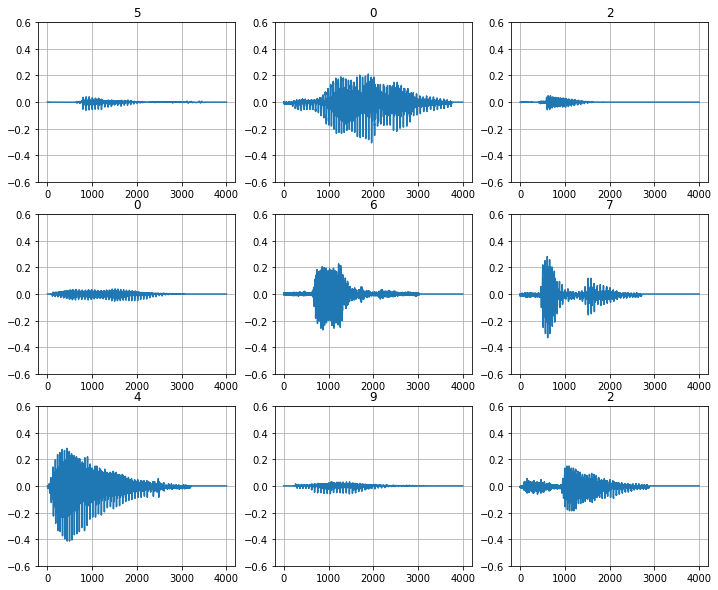

In [8]:
# Wellenformen von 9 Audio-Dateien ausgeben
rows = 3
cols = 3
n = rows*cols

fig,axes = plt.subplots(rows,cols,figsize=(12,10))
for i,(audio,label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-0.6, 0.8, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)
  ax.grid('True')

plt.show()

# Spektrogramm

Jetzt definieren wir die Funktionen zum Erzeugen von Spektrogrammen und lassen uns die Spektrogramme zu den oberen 9 Wellen anzeigen.

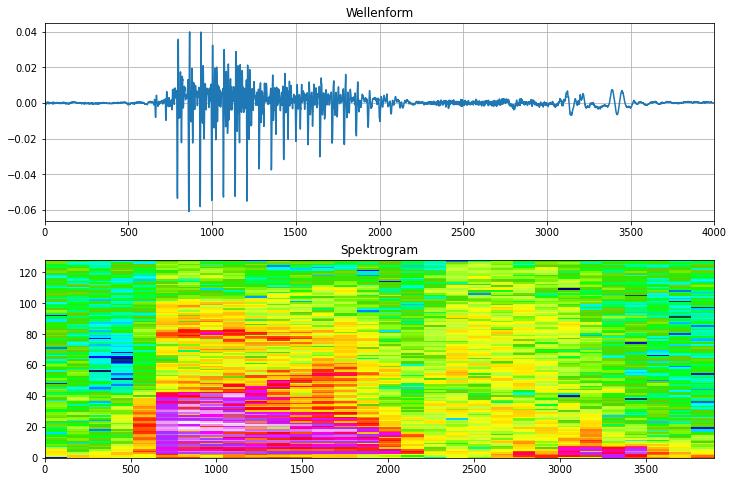

In [9]:
def get_spectrogram(waveform):
  '''Funktion zum transformieren der Wellenform in das Spektrogramm'''
  waveform = tf.cast(waveform, tf.float32)
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)  
  spectrogram = tf.abs(spectrogram)

  return spectrogram

def plot_spectrogram(spectrogram,ax):
  '''Konvertieren die Frequenzen in die logarithmische Skala und transponieren
      sie so, dass die Zeit in der x-Achse dargestellt wird'''
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(sample_rate,step=height+1)
  Y = range(height)
  ax.pcolormesh(X,Y,log_spec,cmap='gist_ncar')

# Eine Wellenform aus dem Datensatz laden und in ein Spektrogramm transformieren
for waveform,label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

# Die eben geladene Wellenform und ihr Spektrogramm anzeigen
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Wellenform')
axes[0].set_xlim([0, sample_rate])
axes[0].grid('True')
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spektrogram')
plt.show()

In [10]:
digits = ['0','1','2','3','4','5','6','7','8','9']
digits = np.array(digits)

def get_spectrogram_and_label_id(audio, label):
  '''Liefert Spektrogramm und das Label als Integer'''
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == digits)
  return spectrogram, label_id

# Das gesamte Wellenform Dataset in Spektrogramme transformieren
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


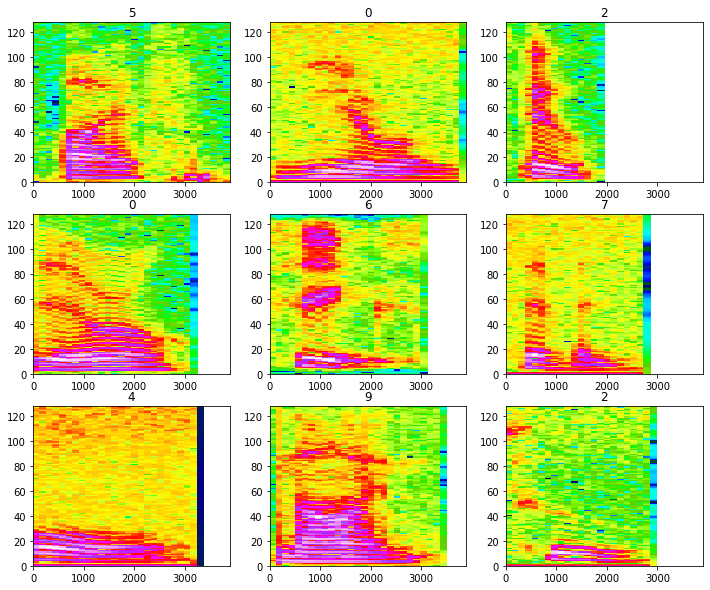

In [11]:
# Spektrogramme der oberen 9 Wellenformen anzeigen lassen
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(digits[label_id.numpy()])
  ax.axis('on')

plt.show()

# Modell erstellen und trainieren

In [12]:
# Mit dieser Funktionen werden die Audio-Dateien zu Tensorflow Datasets transformiert
# Im Dataset befinden sich dann die Spektrogramme und die Labels 
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  files_ds = files_ds.map(get_waveform, num_parallel_calls=AUTOTUNE)
  labels = [get_label(l) for l in files]
  labels = tf.data.Dataset.from_tensor_slices(labels)
  output_ds = tf.data.Dataset.zip((files_ds, labels))
  output_ds = output_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

  return output_ds

# Erstellen der TensorFlow Datasets aus den Validierung- und Test-Daten
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

# Zur Optimierung des Trainings erzeugen wir Batches in den Datasets
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# Rein zur Info sehen wir uns noch die Shape der Spektrogramme an
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
# num_labels gibt die Anzahl der unterschiedlichen Klassen (Labels) an
# für jede Klasse wird im letzten Layer des Netzwerks ein Neuron benötigt
num_labels = len(digits)
print('Anzahl Klassen: ', num_labels)

Input shape: (30, 129, 1)
Anzahl Klassen:  10


In [13]:
# Normalisierung der Pixelwerte 
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),
])

# Zusammenfassung des erzeugten Modells
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [14]:
# Modell kompelieren
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Netzwerk für 10 Epochen trainieren
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS)

Epoch 1/10
38/38 [==============================] - 11s 268ms/step - loss: 1.7749 - accuracy: 0.3754 - val_loss: 0.8856 - val_accuracy: 0.7267
Epoch 2/10
38/38 [==============================] - 8s 198ms/step - loss: 0.8004 - accuracy: 0.7459 - val_loss: 0.5414 - val_accuracy: 0.8400
Epoch 3/10
38/38 [==============================] - 8s 200ms/step - loss: 0.4729 - accuracy: 0.8532 - val_loss: 0.3366 - val_accuracy: 0.9100
Epoch 4/10
38/38 [==============================] - 8s 200ms/step - loss: 0.2834 - accuracy: 0.9205 - val_loss: 0.2846 - val_accuracy: 0.9233
Epoch 5/10
38/38 [==============================] - 8s 199ms/step - loss: 0.2010 - accuracy: 0.9401 - val_loss: 0.2449 - val_accuracy: 0.9300
Epoch 6/10
38/38 [==============================] - 8s 199ms/step - loss: 0.1340 - accuracy: 0.9653 - val_loss: 0.2859 - val_accuracy: 0.9133
Epoch 7/10
38/38 [==============================] - 8s 199ms/step - loss: 0.1273 - accuracy: 0.9638 - val_loss: 0.2941 - val_accuracy: 0.9133
Epoch

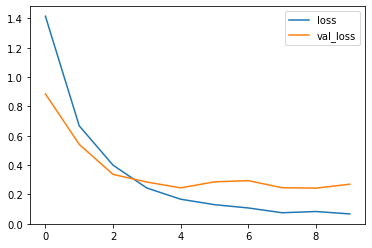

In [15]:
# Den Verlauf der beiden Loss-Kurven des Trainings anzeigen
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

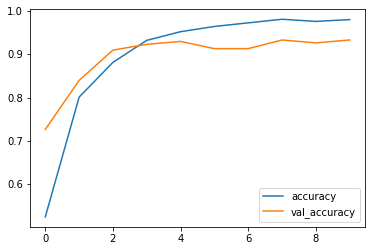

In [16]:
# Den Verlauf der beiden Accuracy-Kurven des Trainings anzeigen
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

# Modell Testen

Mit den 300 Audio-Dateien aus dem Test-Datensatz, die im Training nicht verwendet wurden, testen wir unser Modell.

In [17]:
test_audio = []
test_labels = []

for audio,label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio),axis=1)
y_true = test_labels

# test_acc gibt in Prozent an, wie viele der 300 unbekannten 
# Audio-Dateien richtig klassifiziert wurden
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set acc: {test_acc:.0%}')

Test set acc: 93%
